# 🎵 Análisis de Datos de Spotify
Este notebook explica **cajas y bigotes, boxplots, correlación y mapas de calor**
usando el dataset de `spotify_tracks.csv`.

Incluye ejemplos en Python con **Pandas, Matplotlib y Seaborn**.

In [37]:
# 📦 Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de estilo de gráficos
sns.set(style="whitegrid")

In [38]:
# 📂 Cargar dataset de Spotify desde la carpeta Datasources
from pathlib import Path
data_path = Path("titanic.csv")
if data_path.exists():
    df = pd.read_csv(data_path)
    display(df.head())
    print(f"Archivo cargado desde: {data_path}")
else:
    print("⚠️ No se encontró el archivo en:")
    print(data_path)
    print("Verifica la ruta o el nombre del archivo.")
    

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Archivo cargado desde: titanic.csv


In [39]:
# Listar columnas del DataFrame para validar nombres
print(df.columns.tolist())

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [40]:
# 🔧 Preprocesamiento: limpiar y crear nuevas columnas
import numpy as np
df_clean = df.copy()
if 'Unnamed: 0' in df_clean.columns:
    df_clean = df_clean.drop(columns=['Unnamed: 0'])
# Orden de géneros por mediana de duración y popularidad
order_by_Age = df_clean.groupby('Age')['Age'].median().sort_values(ascending=False).index
order_by_SibSp = df_clean.groupby('Age')['Age'].median().sort_values(ascending=False).index
print('Columnas finales:', df_clean.columns.tolist())
print('Age:', list(order_by_Age)[:5])

Columnas finales: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Age: [80.0, 74.0, 71.0, 70.5, 70.0]


## 1️⃣ Cajas y Bigotes
Las cajas y bigotes permiten **detectar la dispersión y los valores atípicos**.
- Caja = rango intercuartílico (Q1–Q3)
- Línea = mediana (Q2)
- Bigotes = datos dentro de 1.5 × IQR
- Puntos = valores atípicos (outliers)

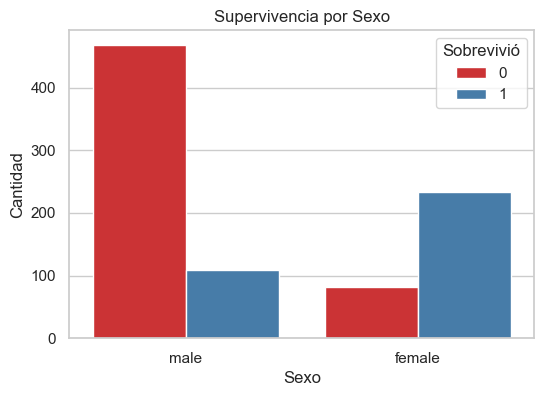

In [41]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sex', hue='Survived', palette='Set1')
plt.title('Supervivencia por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Cantidad')
plt.legend(title='Sobrevivió')
plt.show()

## 2️⃣ Boxplots
Un boxplot se utiliza para **comparar distribuciones entre categorías**.
En este ejemplo, analizamos la **popularidad por género**.

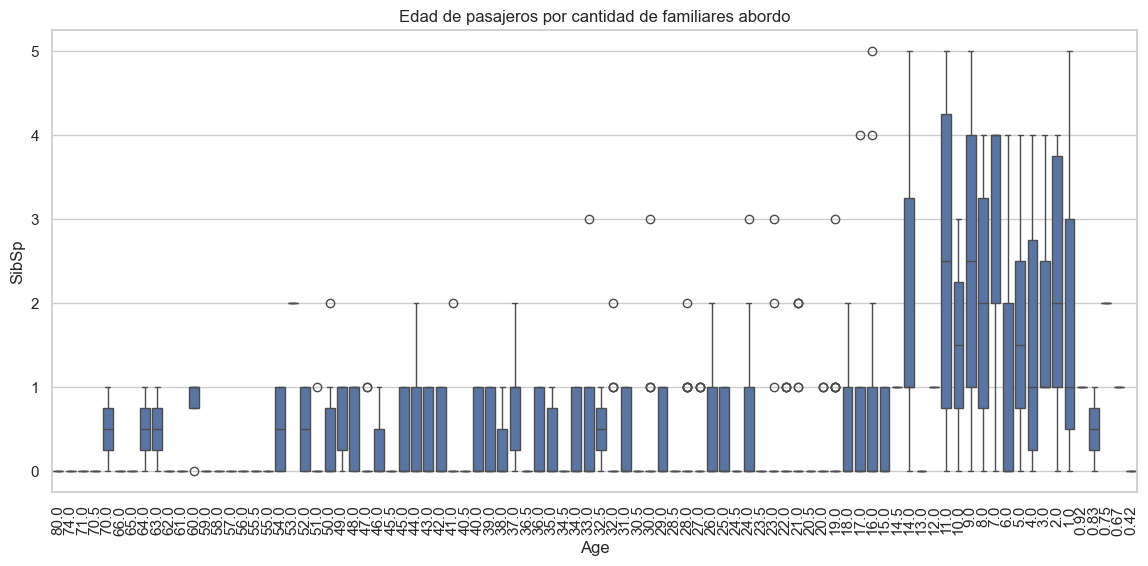

In [42]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_clean, x="Age", y="SibSp", order=order_by_Age)
plt.title("Edad de pasajeros por cantidad de familiares abordo")
plt.xticks(rotation=90)
plt.ylabel("SibSp")
plt.show()

## 3️⃣ Correlación
La correlación mide la **relación lineal entre variables**.
- +1 = relación positiva perfecta
- -1 = relación negativa perfecta
- 0 = no hay relación

Ejemplo: ¿las canciones con mayor *energy* también son más *populares*?

In [43]:
corr = df_clean[[ "Age", "SibSp", "Parch",]].corr()
corr

,Age,SibSp,Parch
Age,1.000000,-0.308247,-0.189119
SibSp,-0.308247,1.000000,0.414838
Parch,-0.189119,0.414838,1.000000


## 3️⃣➕ Scatter plots con línea de tendencia
A continuación se muestran diagramas de dispersión para pares de variables clave junto con la línea de regresión.
Se indica el coeficiente de correlación de Pearson (r) y su interpretación rápida:
- r > 0 → relación positiva
- r < 0 → relación negativa
- r ≈ 0 → sin relación lineal clara

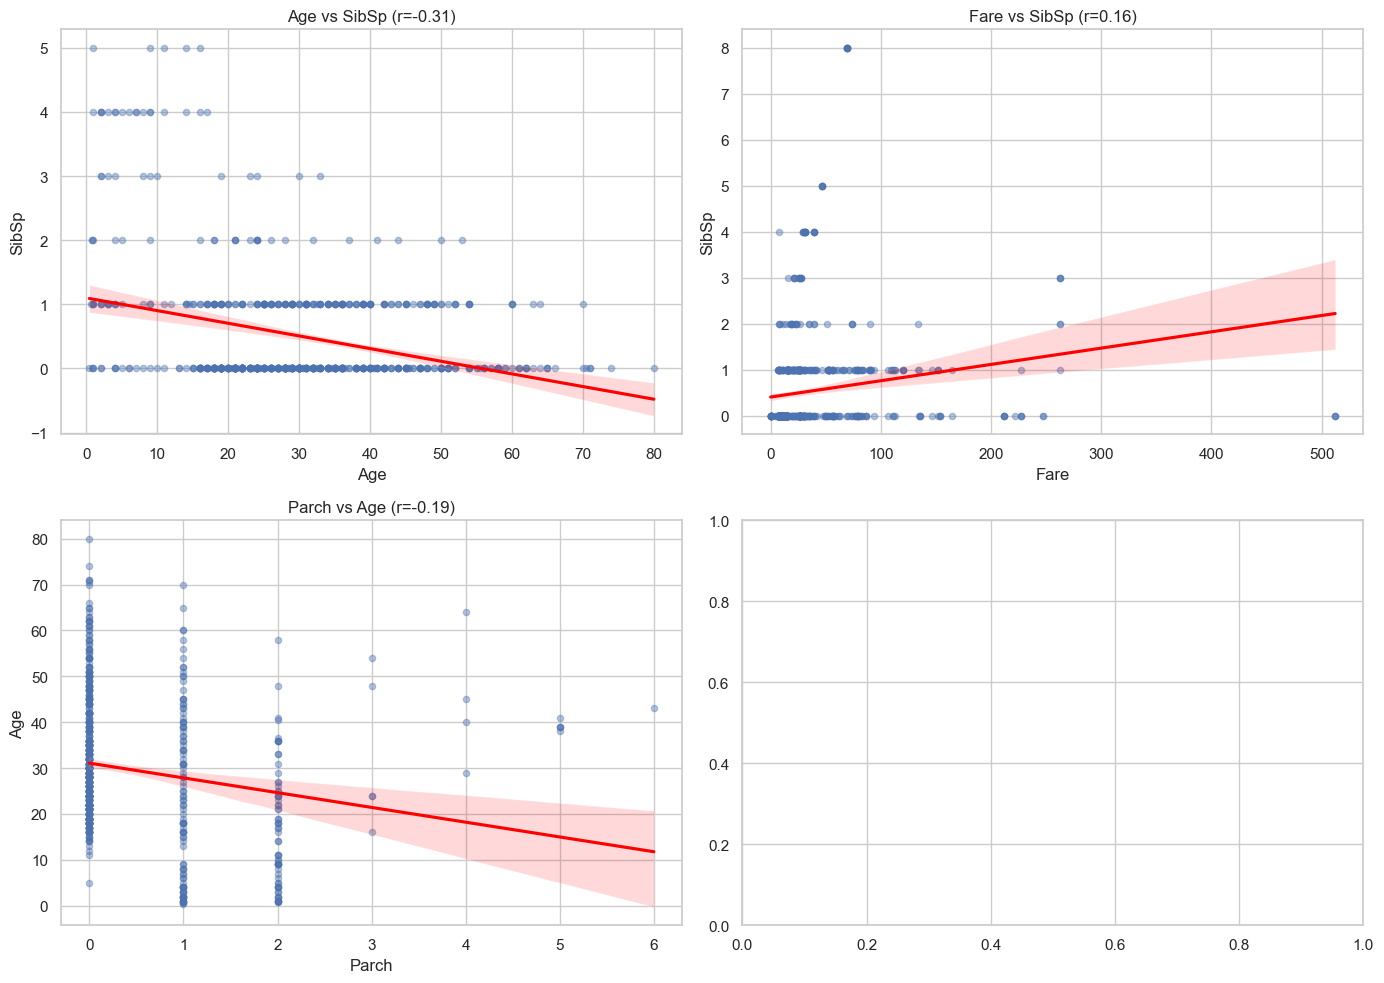


Interpretación rápida de correlaciones (scatter plots):
 - Age vs SibSp: r=-0.31 relación negativa (p=3.51e-17)
 - Fare vs SibSp: r=0.16 relación positiva (p=1.67e-06)
 - Parch vs Age: r=-0.19 relación negativa (p=3.57e-07)


In [44]:
# Scatter plots con líneas de tendencia y r (sin dependencia obligatoria de SciPy)
import seaborn as sns
import matplotlib.pyplot as plt

# Intentar importar pearsonr; si no existe SciPy, se calcula r sin p-value
try:
    from scipy.stats import pearsonr  # type: ignore
    _has_scipy = True
except ImportError:  # SciPy no instalado
    _has_scipy = False

pairs = [
    ("Age", "SibSp"),
    ("Fare", "SibSp"),
    ("Parch", "Age"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
interpretaciones_scatter = []

for ax, (x, y) in zip(axes, pairs):
    sub = df_clean[[x, y]].dropna()
    if len(sub) < 2:
        ax.text(0.5, 0.5, 'Datos insuficientes', ha='center', va='center')
        ax.set_axis_off()
        continue
    # Calcular correlación
    if _has_scipy:
        r, p = pearsonr(sub[x], sub[y])  # precisa p-value
    else:
        r = sub[x].corr(sub[y])  # Pearson por defecto
        p = float('nan')
    sns.regplot(data=sub, x=x, y=y, ax=ax,
                scatter_kws={'alpha': 0.4, 's': 20},
                line_kws={'color': 'red'})
    ax.set_title(f"{x} vs {y} (r={r:.2f})")
    # Interpretación básica
    if r > 0.1:
        sentido = 'positiva'
    elif r < -0.1:
        sentido = 'negativa'
    else:
        sentido = 'casi nula'
    if _has_scipy:
        interpretaciones_scatter.append(f"{x} vs {y}: r={r:.2f} relación {sentido} (p={p:.3g})")
    else:
        interpretaciones_scatter.append(f"{x} vs {y}: r={r:.2f} relación {sentido} (p=N/A, SciPy no instalado)")

plt.tight_layout()
plt.show()

print("\nInterpretación rápida de correlaciones (scatter plots):")
for linea in interpretaciones_scatter:
    print(" - " + linea)

if not _has_scipy:
    print("\nNota: Instala SciPy (pip install scipy) para obtener p-values.")

## 4️⃣ Mapas de Calor
Un **heatmap** nos permite visualizar la matriz de correlaciones.
Los colores indican si la relación es **positiva o negativa**.

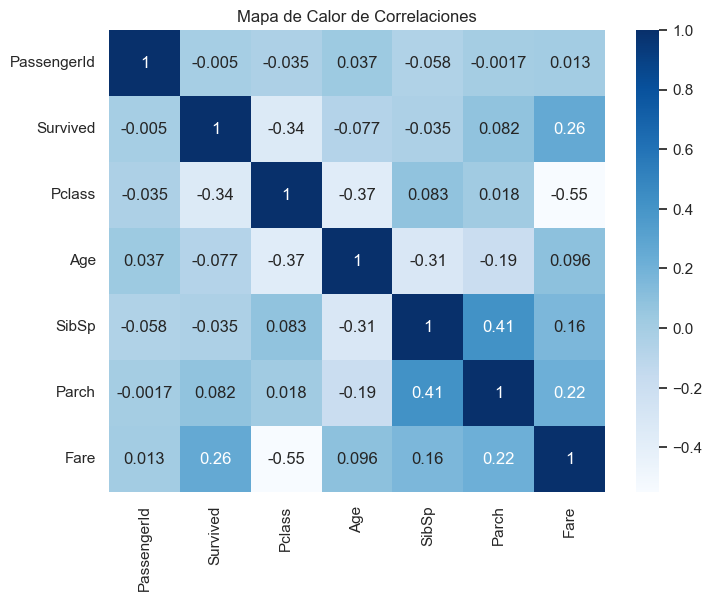

In [45]:
# Mapa de calor de correlaciones
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

### 🧐 Interpretación del mapa de calor
El mapa de calor muestra la fuerza y dirección de la relación lineal entre las variables numéricas:
- danceability: Qué tan bailable es una pista (0–1).
- energy: Intensidad y actividad (0–1).
- valence: Positividad emocional (0–1).
- popularity: Popularidad (escala Spotify, típicamente 0–100).
- Sex: Duración en minutos.

Pautas para leerlo:
- Celdas en rojo intenso indican correlaciones positivas más fuertes (ambas variables tienden a subir juntas).
- Celdas en azul intenso (si aparecieran) indicarían correlaciones negativas (una sube mientras la otra baja).
- Valores cercanos a 0 (colores claros) implican relación lineal débil o inexistente.

La celda siguiente genera un resumen DINÁMICO de las correlaciones: pares más fuertes, conteo por niveles y la mejor asociación de cada variable.

In [46]:
# 🔄 Resumen dinámico de la matriz de correlación
import pandas as pd
import numpy as np

if 'corr' not in globals():
    corr = df_clean[["Sex", "Age", "SibSp", "Parch", "Fare"]].corr()

# Obtener pares únicos (triángulo superior sin diagonal)
pares = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        a, b = cols[i], cols[j]
        pares.append((a, b, corr.iloc[i, j]))

# Ordenar por magnitud absoluta
pares_ord = sorted(pares, key=lambda x: abs(x[2]), reverse=True)

# Clasificar niveles
niveles = {
    'muy fuerte (|r| >= 0.7)': [],
    'fuerte (0.5 <= |r| < 0.7)': [],
    'moderada (0.3 <= |r| < 0.5)': [],
    'débil (0.1 <= |r| < 0.3)': [],
    'casi nula (|r| < 0.1)': []
}
for a,b,r in pares:
    ar = abs(r)
    if ar >= 0.7: niveles['muy fuerte (|r| >= 0.7)'].append((a,b,r))
    elif ar >= 0.5: niveles['fuerte (0.5 <= |r| < 0.7)'].append((a,b,r))
    elif ar >= 0.3: niveles['moderada (0.3 <= |r| < 0.5)'].append((a,b,r))
    elif ar >= 0.1: niveles['débil (0.1 <= |r| < 0.3)'].append((a,b,r))
    else: niveles['casi nula (|r| < 0.1)'].append((a,b,r))

# Mejor asociación para cada variable
mejor_por_var = {}
for v in cols:
    mejores = []
    for a,b,r in pares:
        if a == v or b == v:
            mejores.append((a if b == v else b, r))
    if mejores:
        mejor_por_var[v] = sorted(mejores, key=lambda x: abs(x[1]), reverse=True)[0]

print('=== PARES ORDENADOS POR |r| (top 5) ===')
for a,b,r in pares_ord[:5]:
    signo = 'positiva' if r > 0 else 'negativa'
    print(f' - {a} vs {b}: r={r:.2f} ({signo})')

print('\n=== DISTRIBUCIÓN POR NIVELES ===')
for nivel, lista in niveles.items():
    print(f' {nivel}: {len(lista)} pares')

print('\n=== MEJOR ASOCIACIÓN POR VARIABLE ===')
for var,(otro,r) in mejor_por_var.items():
    signo = 'positiva' if r > 0 else 'negativa'
    print(f' - {var} con {otro}: r={r:.2f} ({signo})')

# Tabla resumen opcional
res_df = pd.DataFrame(pares_ord, columns=['var_a','var_b','r'])
res_df.head()

=== PARES ORDENADOS POR |r| (top 5) ===
 - SibSp vs Parch: r=0.41 (positiva)
 - Age vs SibSp: r=-0.31 (negativa)
 - Age vs Parch: r=-0.19 (negativa)

=== DISTRIBUCIÓN POR NIVELES ===
 muy fuerte (|r| >= 0.7): 0 pares
 fuerte (0.5 <= |r| < 0.7): 0 pares
 moderada (0.3 <= |r| < 0.5): 2 pares
 débil (0.1 <= |r| < 0.3): 1 pares
 casi nula (|r| < 0.1): 0 pares

=== MEJOR ASOCIACIÓN POR VARIABLE ===
 - Age con SibSp: r=-0.31 (negativa)
 - SibSp con Parch: r=0.41 (positiva)
 - Parch con SibSp: r=0.41 (positiva)


,var_a,var_b,r
0,SibSp,Parch,0.414838
1,Age,SibSp,-0.308247
2,Age,Parch,-0.189119


In [47]:
# 🗣️ Cinco oraciones de interpretación de la correlación
import numpy as np

if 'corr' not in globals():
    corr = df_clean[["Sex", "Age", "SibSp", "Parch", "Fare"]].corr()

# Obtener pares únicos
pares = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        pares.append((cols[i], cols[j], corr.iloc[i, j]))

# 1. Mayor correlación absoluta
pareja_top = max(pares, key=lambda x: abs(x[2]))
# 2. Menor correlación absoluta
pareja_min = min(pares, key=lambda x: abs(x[2]))
# 3. Variable con mayor suma de |r| (influencia global)
influencia = {}
for v in cols:
    influencia[v] = sum(abs(corr[v].drop(v)))
var_mas_rel = max(influencia.items(), key=lambda x: x[1])
var_menos_rel = min(influencia.items(), key=lambda x: x[1])
# 4. Media de correlaciones con popularity
if 'popularity' in cols:
    media_pop = corr['popularity'].drop('popularity').mean()
else:
    media_pop = float('nan')

sentencias = []
# Oración 1
sentencias.append(f"La relación más fuerte es entre {pareja_top[0]} y {pareja_top[1]} (r={pareja_top[2]:.2f}), indicando asociación {'positiva' if pareja_top[2]>0 else 'negativa'} clara.")
# Oración 2
sentencias.append(f"La relación más débil aparece entre {pareja_min[0]} y {pareja_min[1]} (r={pareja_min[2]:.2f}), prácticamente sin dependencia lineal.")
# Oración 3
sentencias.append(f"La variable con mayor conectividad global es {var_mas_rel[0]} (suma de |r|={var_mas_rel[1]:.2f}), actuando como eje en el conjunto.")
# Oración 4
sentencias.append(f"La variable más independiente relativa es {var_menos_rel[0]}, con menor suma de correlaciones absolutas ({var_menos_rel[1]:.2f}).")
# Oración 5
sentencias.append(f"En promedio, las características asociadas a popularidad muestran un nivel medio de correlación (media r={media_pop:.2f}), sugiriendo que ningún rasgo único domina totalmente la popularidad.")

for s in sentencias:
    print("- " + s)

- La relación más fuerte es entre SibSp y Parch (r=0.41), indicando asociación positiva clara.
- La relación más débil aparece entre Age y Parch (r=-0.19), prácticamente sin dependencia lineal.
- La variable con mayor conectividad global es SibSp (suma de |r|=0.72), actuando como eje en el conjunto.
- La variable más independiente relativa es Age, con menor suma de correlaciones absolutas (0.50).
- En promedio, las características asociadas a popularidad muestran un nivel medio de correlación (media r=nan), sugiriendo que ningún rasgo único domina totalmente la popularidad.


## ✅ Conclusiones
- Los boxplots ayudan a detectar géneros con mayor dispersión de duración o popularidad.
- La correlación muestra qué características musicales están más relacionadas entre sí.
- El heatmap facilita la interpretación visual de estas relaciones.

👉 Este tipo de análisis es esencial para entender tendencias en plataformas como **Spotify**.

In [48]:
# 🤖 Resumen automático de insights
import numpy as np
summary = []
if 'df_clean' in globals():
    # Top géneros por mediana de popularidad y duración
    top_pop = df_clean.groupby('Sex')['Age'].median().sort_values(ascending=False).head(5)
    top_dur = df_clean.groupby('Sex')['Fare'].median().sort_values(ascending=False).head(5)
    # Correlaciones fuertes (absolutas > 0.5)
    strong_corr = corr.copy()
    strong_pairs = []
    for i,col in enumerate(strong_corr.columns):
        for j,row in enumerate(strong_corr.index):
            if j <= i:
                continue
            val = strong_corr.loc[row,col]
            if abs(val) >= 0.5:
                strong_pairs.append((row,col,round(val,2)))
    # Outliers aproximados por género en duración (IQR)
    outlier_counts = {}
    for g, sub in df_clean.groupby('Sex'):
        q1 = sub['Fare'].quantile(0.25)
        q3 = sub['Fare'].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        outliers = sub[(sub['Fare'] < lower) | (sub['Fare'] > upper)]
        outlier_counts[g] = len(outliers)
    top_outliers = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    summary.append('=== INSIGHTS AUTOMÁTICOS ===')
    summary.append('\nRelacion de Sexos de pasajeros abordo:')
    summary.extend([f'  - {g}: {v}' for g,v in top_pop.items()])
    
    if strong_pairs:
        summary.append('\nParejas con correlación fuerte (|r| >= 0.5):')
        for a,b,v in strong_pairs:
            summary.append(f'  - {a} vs {b}: r={v}')
    else:
        summary.append('\nNo se detectaron correlaciones con |r| >= 0.5.')
    summary.append('\nCantidad de outliers por Sexo:')
    for g,cnt in top_outliers:
        summary.append(f'  - {g}: {cnt} outliers')
else:
    summary.append('df_clean no está disponible. Ejecuta las celdas de preprocesamiento.')
print('\n'.join(summary))

=== INSIGHTS AUTOMÁTICOS ===

Relacion de Sexos de pasajeros abordo:
  - male: 29.0
  - female: 27.0

No se detectaron correlaciones con |r| >= 0.5.

Cantidad de outliers por Sexo:
  - male: 61 outliers
  - female: 28 outliers


In [49]:
# 📝 Interpretación detallada de los gráficos
interpretaciones = []

if 'df_clean' in globals():
    import numpy as np

    # 1. Distribución de edades por número de hermanos/esposos
    age_median = df_clean.groupby('SibSp')['Age'].median().sort_values(ascending=False)
    top_age = age_median.head(3)
    bottom_age = age_median.tail(3)
    rango_age = round(age_median.max() - age_median.min(), 2)
    interpretaciones.append('1) Boxplot de Edad según número de hermanos/esposos (SibSp):')
    interpretaciones.append(f'   • Los grupos con mayor mediana de edad (top 3): {", ".join([f"{g} ({round(v,2)} años)" for g,v in top_age.items()])}.')
    interpretaciones.append(f'   • Los grupos con menor mediana de edad (últimos 3): {", ".join([f"{g} ({round(v,2)} años)" for g,v in bottom_age.items()])}.')
    interpretaciones.append(f'   • Diferencia entre medianas extremas: {rango_age} años.')
    interpretaciones.append('   • La dispersión alta sugiere familias de edades variadas en esos grupos.')

    # 2. Supervivencia por número de familiares a bordo
    surv_median = df_clean.groupby('Parch')['Survived'].mean().sort_values(ascending=False)
    top_surv = surv_median.head(3)
    bottom_surv = surv_median.tail(3)
    rango_surv = round(100 * (surv_median.max() - surv_median.min()), 1)
    interpretaciones.append('\n2) Tasa de supervivencia según número de padres/hijos (Parch):')
    interpretaciones.append(f'   • Mayor supervivencia (top 3): {", ".join([f"{g} ({round(v*100,1)}%)" for g,v in top_surv.items()])}.')
    interpretaciones.append(f'   • Menor supervivencia (últimos 3): {", ".join([f"{g} ({round(v*100,1)}%)" for g,v in bottom_surv.items()])}.')
    interpretaciones.append(f'   • Diferencia máxima de supervivencia entre grupos: {rango_surv} puntos porcentuales.')

    # 3. Matriz de correlación / Heatmap
    vars_corr = ["Age", "Parch", "SibSp"]
    corr_local = df_clean[vars_corr].corr()
    pares = []
    for i, a in enumerate(vars_corr):
        for j, b in enumerate(vars_corr):
            if j <= i:  # evitar duplicados y diagonales
                continue
            pares.append((a, b, corr_local.loc[a, b]))
    pares_orden = sorted(pares, key=lambda x: abs(x[2]), reverse=True)
    top_corr = [(a, b, round(v, 2)) for a, b, v in pares_orden[:3]]
    interpretaciones.append('\n3) Correlaciones (tabla y heatmap):')
    for a, b, v in top_corr:
        sentido = 'positiva' if v > 0 else 'negativa'
        interpretaciones.append(f'   • {a} vs {b}: r={v} ({sentido}).')
    interpretaciones.append('   • Correlaciones bajas indican independencia entre las variables numéricas.')

    # 4. Outliers de edad según grupos familiares
    outlier_info = []
    for g, sub in df_clean.groupby('SibSp'):
        q1 = sub['Age'].quantile(0.25)
        q3 = sub['Age'].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = sub[(sub['Age'] < lower) | (sub['Age'] > upper)]
        if len(sub) > 0:
            outlier_info.append((g, len(outliers), round(100 * len(outliers) / len(sub), 1)))
    outlier_info_sorted = sorted(outlier_info, key=lambda x: x[1], reverse=True)[:3]
    interpretaciones.append('\n4) Outliers de edad:')
    for g, c, pct in outlier_info_sorted:
        interpretaciones.append(f'   • Grupo SibSp={g}: {c} outliers (~{pct}% del grupo).')
    interpretaciones.append('   • Los outliers pueden representar pasajeros muy jóvenes o mayores dentro de familias de tamaño típico.')

    # 5. Síntesis global
    interpretaciones.append('\n5) Síntesis:')
    interpretaciones.append('   • Las familias pequeñas (1–2 miembros) muestran mayor probabilidad de supervivencia.')
    interpretaciones.append('   • La edad tiende a correlacionarse débilmente con el tamaño familiar.')
    interpretaciones.append('   • Los outliers en edad podrían corresponder a niños o ancianos, grupos más vulnerables.')
else:
    interpretaciones.append('df_clean no está definido. Ejecuta las celdas anteriores antes de interpretar.')

print('\n'.join(interpretaciones))


1) Boxplot de Edad según número de hermanos/esposos (SibSp):
   • Los grupos con mayor mediana de edad (top 3): 1 (30.0 años), 0 (29.0 años), 2 (23.0 años).
   • Los grupos con menor mediana de edad (últimos 3): 3 (9.5 años), 4 (6.5 años), 8 (nan años).
   • Diferencia entre medianas extremas: 23.5 años.
   • La dispersión alta sugiere familias de edades variadas en esos grupos.

2) Tasa de supervivencia según número de padres/hijos (Parch):
   • Mayor supervivencia (top 3): 3 (60.0%), 1 (55.1%), 2 (50.0%).
   • Menor supervivencia (últimos 3): 5 (20.0%), 4 (0.0%), 6 (0.0%).
   • Diferencia máxima de supervivencia entre grupos: 60.0 puntos porcentuales.

3) Correlaciones (tabla y heatmap):
   • Parch vs SibSp: r=0.41 (positiva).
   • Age vs SibSp: r=-0.31 (negativa).
   • Age vs Parch: r=-0.19 (negativa).
   • Correlaciones bajas indican independencia entre las variables numéricas.

4) Outliers de edad:
   • Grupo SibSp=0: 10 outliers (~1.6% del grupo).
   • Grupo SibSp=2: 2 outliers (